In [333]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [334]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
from sklearn.preprocessing import LabelEncoder

# Práctica 5: Introducción a Modelos de Clasificación

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Implemente una clase  que permita ajustar un modelo KNN. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.
- La clase debe permitir el uso de la distancia Mikownski y similitud coseno.

El algoritmo k-vecinos más cercanos (KNN) es un simple algoritmo de aprendizaje automático supervisado que se puede utilizar para resolver problemas de clasificación y regresión. Es fácil de implementar y comprender, pero tiene un inconveniente importante de volverse significativamente más lento a medida que crece el tamaño de los datos en uso.

KNN trabaja buscando las distancias entre una consulta y todos los ejemplos en los datos, seleccionando el número especificado ejemplos (K) más cercanos a la consulta, luego vota por la etiqueta más frecuente (en el caso de la clasificación) o promedia las etiquetas (en el caso de la regresión).

En el caso de la clasificación y la regresión, vimos esa elección la K correcta para nuestros datos se hace probando varios Ks y escogiendo el que mejor funciona.

__Clase implementada de KNN__

In [335]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

class KNN:
    def __init__(self, n_neighbors=5, metric='euclidean', p=2):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p
        
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
    
    def predict(self, x_test):
        start_time = time.time()
        n_samples = len(x_test)
        y_pred = np.zeros(n_samples)
        
        if self.metric == 'euclidean':
            for i, x in enumerate(x_test):
                distances = np.sqrt(np.sum((self.x_train - x) ** 2, axis=1))
                nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
                nearest_labels = self.y_train.iloc[nearest_neighbors]
                y_pred[i] = nearest_labels.mode()[0]
                elapsed_time = time.time() - start_time
                print(f"Progress: {i+1}/{n_samples} - Elapsed Time: {elapsed_time:.2f} seconds")
        
        elif self.metric == 'cosine':
            x_train_norm = np.linalg.norm(self.x_train, axis=1)
            x_test_norm = np.linalg.norm(x_test, axis=1)
            for i, x in enumerate(x_test):
                similarities = 1 - cosine_distances(x.reshape(1, -1), self.x_train)[0]
                nearest_neighbors = np.argsort(similarities)[::-1][:self.n_neighbors]
                nearest_labels = self.y_train.iloc[nearest_neighbors]
                y_pred[i] = nearest_labels.mode()[0]
                elapsed_time = time.time() - start_time
                print(f"Progress: {i+1}/{n_samples} - Elapsed Time: {elapsed_time:.2f} seconds")
        
        elif self.metric == 'minkowski':
            for i, x in enumerate(x_test):
                distances = np.power(np.sum(np.power(np.abs(self.x_train - x), self.p), axis=1), 1/self.p)
                nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
                nearest_labels = self.y_train.iloc[nearest_neighbors]
                y_pred[i] = nearest_labels.mode()[0]
                elapsed_time = time.time() - start_time
                print(f"Progress: {i+1}/{n_samples} - Elapsed Time: {elapsed_time:.2f} seconds")
        
        return y_pred


## Asignación 2

Implemente una clase que permita ajustar un modelo Naive Bayes. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.

En esta sección se incluye un dataset real. El dataset importado se llama _spambase_ y puede leer su descripción en la siguiente liga

https://www.openml.org/d/42904

In [336]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(42904, download_data=False)

target = "CLASS"

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    _, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

columns = np.array(columns)

In [337]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")

La columna a predecir se llama 'CLASS'
Todas las características son ['COMMENT_ID' 'AUTHOR' 'DATE' 'CONTENT']


In [338]:
# Impresión de las características
features
# Eliminar las características que no se pueden utilizar para predecir
features = features.drop(columns=["COMMENT_ID", "AUTHOR", "DATE"])

In [339]:
prefeatures = features
features

,CONTENT
0,"Huh, anyway check out this you[tube] channel: ..."
1,Hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿
...,...
345,How can this have 2 billion views when there's...
346,I don't now why I'm watching this in 2014﻿
347,subscribe to me for call of duty vids and give...
348,hi guys please my android photo editor downloa...


__Implementacion de NaiveBayes__

In [340]:
import math
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm


class NaiveBayesClassifier:
    def __init__(self, max_features=4000):
        self.max_features = max_features
        self.vec = CountVectorizer(max_features=self.max_features)
        self.vocab = None
        self.word_counts = None
        self.n_label_items = None
        self.log_label_priors = None
    
    def _laplace_smoothing(self, n_label_items, vocab, word_counts, word, text_label):
        a = word_counts[text_label][word] + 1
        b = n_label_items[text_label] + len(vocab)
        return math.log(a/b)
    
    def _group_by_label(self, x, y, labels):
        data = {}
        for l in labels:
            data[l] = x[np.where(y == l)]
        return data
    
    def fit(self, x, y):
        labels = list(set(y))
        X = self.vec.fit_transform(x)
        self.vocab = self.vec.get_feature_names_out()
        X = X.toarray()
        self.word_counts = {}
        for l in range(len(labels)):
            self.word_counts[l] = defaultdict(lambda: 0)
        for i in tqdm(range(X.shape[0]), desc="Counting words"):
            l = y[i]
            for j in range(len(self.vocab)):
                self.word_counts[l][self.vocab[j]] += X[i][j]
        self.n_label_items = {}
        self.log_label_priors = {}
        n = len(x)
        grouped_data = self._group_by_label(X, y, labels)
        for l, data in grouped_data.items():
            self.n_label_items[l] = len(data)
            self.log_label_priors[l] = math.log(self.n_label_items[l] / n)
    
    def predict(self, x):
        result = []
        for text in tqdm(x, desc="Predicting"):
            label_scores = {l: self.log_label_priors[l] for l in self.n_label_items.keys()}
            words = set(self.vec.build_tokenizer()(text))
            for word in words:
                if word not in self.vocab: continue
                for l in self.n_label_items.keys():
                    log_w_given_l = self._laplace_smoothing(self.n_label_items, self.vocab, self.word_counts, word, l)
                    label_scores[l] += log_w_given_l
            result.append(max(label_scores, key=label_scores.get))
        return result


## Asignación 3

Realice el preprocesamiento que considere adecuado para que el dataset pueda ser procesado por un modelo de clasificación. __No olvide utilizar particionar en entrenamiento y validación, y realizar el preprocesamiento de manera adecuada__.

In [341]:
#unir en un solo dataframe las caracteristicas y la columna a predecir
data = pd.concat([features, outputs], axis=1)

__Preprocesamiento elegido ->__

In [342]:
import pandas as pd
import numpy as np
import re
import nltk

# Separa los comentarios y etiquetas en dos arrays diferentes

comentarios = data['CONTENT']
etiquetas = data['CLASS']

def preprocesar_comentarios(comentarios):
    # Elimina caracteres no deseados
    comentarios = comentarios.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    #cambiar las url por la palabra url
    comentarios = comentarios.apply(lambda x: re.sub(r'http[s]://.', 'url', x, flags=re.MULTILINE))
    # Convierte a minúsculas
    comentarios = comentarios.apply(lambda x: x.lower())
    # Elimina stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    comentarios = comentarios.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # Lematiza palabras
    lemmatizer = nltk.WordNetLemmatizer()
    comentarios = comentarios.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return comentarios

comentarios = preprocesar_comentarios(comentarios)
#concatener comentarios + etiquetas en un solo dataframe
data = pd.concat([comentarios, etiquetas], axis=1)
print(data)


                                               CONTENT  CLASS
0          huh anyway check youtube channel kobyoshi02      1
1    hey guy check new channel first vid u monkey i...      1
2                                   test say murdevcom      1
3                      shaking sexy as channel enjoy _      1
4                              watchvvtarggvgtwq check      1
..                                                 ...    ...
345                    2 billion view there planet lol      0
346                              dont im watching 2014      0
347    subscribe call duty vids give aways goal100 sub      1
348  hi guy please android photo editor download th...      1
349  first billion viewed thought really cool billi...      0

[350 rows x 2 columns]


## Asignación 4

Realice una visualización de los datos en dos dimensiones. Posteriormente entrene un modelo de KNN (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

---------------------------------

In [343]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [344]:
#instalar punkt
#nltk.download('punkt')

In [345]:
def etiquetar_documentos(docs):
    return [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(docs)]

# Función para entrenar el modelo Doc2Vec
def entrenar_doc2vec(docs):
    docs_etiquetados = etiquetar_documentos(docs)
    modelo = Doc2Vec(vector_size=500, min_count=5, epochs=100)
    modelo.build_vocab(docs_etiquetados)
    modelo.train(docs_etiquetados, total_examples=modelo.corpus_count, epochs=modelo.epochs)
    return modelo

modelo_doc2vec = entrenar_doc2vec(comentarios)
def preprocesar_comentario(comentario):
    tokens = word_tokenize(comentario.lower())
    return modelo_doc2vec.infer_vector(tokens)

#prepro
comentarios_preprocesados = [preprocesar_comentario(comentario) for comentario in comentarios]

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(comentarios_preprocesados, etiquetas, test_size=0.2, random_state=42)

In [348]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
knn = KNN(n_neighbors=3, metric='cosine')
knn.fit(X_train, y_train)
# Fit the model to the training data

# Predict on the test set
y_pred = knn.predict(X_test)

# Compute the accuracy score on the test set
score = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Precisión: {score:.4f}")

Progress: 1/70 - Elapsed Time: 0.00 seconds
Progress: 2/70 - Elapsed Time: 0.00 seconds
Progress: 3/70 - Elapsed Time: 0.00 seconds
Progress: 4/70 - Elapsed Time: 0.01 seconds
Progress: 5/70 - Elapsed Time: 0.01 seconds
Progress: 6/70 - Elapsed Time: 0.01 seconds
Progress: 7/70 - Elapsed Time: 0.01 seconds
Progress: 8/70 - Elapsed Time: 0.01 seconds
Progress: 9/70 - Elapsed Time: 0.01 seconds
Progress: 10/70 - Elapsed Time: 0.01 seconds
Progress: 11/70 - Elapsed Time: 0.01 seconds
Progress: 12/70 - Elapsed Time: 0.01 seconds
Progress: 13/70 - Elapsed Time: 0.01 seconds
Progress: 14/70 - Elapsed Time: 0.01 seconds
Progress: 15/70 - Elapsed Time: 0.01 seconds
Progress: 16/70 - Elapsed Time: 0.02 seconds
Progress: 17/70 - Elapsed Time: 0.02 seconds
Progress: 18/70 - Elapsed Time: 0.02 seconds
Progress: 19/70 - Elapsed Time: 0.02 seconds
Progress: 20/70 - Elapsed Time: 0.02 seconds
Progress: 21/70 - Elapsed Time: 0.02 seconds
Progress: 22/70 - Elapsed Time: 0.02 seconds
Progress: 23/70 - E

In [349]:
# Preprocess the new comments
new_comments = [
     "i hate this video",
    "pls contact me 55489701 free bitcoin",
    "check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y",
    "sub me pls and i will sub you back",
    "sus pls to my channel",
    "this song is beeter in live",
    "i dont know what im doing here",
    "i love this video",
]
new_comments_preprocessed = [preprocesar_comentario(comentario) for comentario in new_comments]

# Make predictions on the new comments
predictions = knn.predict(new_comments_preprocessed)
print("Prediccion de Bayes")
# Print the predicted labels
for comment, prediction in zip(new_comments, predictions):
    if prediction == 1:
        print(f"Este comentario: {comment} Es spam \n")
    else:
        print(f"Este comentario:: {comment} No es spam \n")


Progress: 1/8 - Elapsed Time: 0.00 seconds
Progress: 2/8 - Elapsed Time: 0.00 seconds
Progress: 3/8 - Elapsed Time: 0.00 seconds
Progress: 4/8 - Elapsed Time: 0.00 seconds
Progress: 5/8 - Elapsed Time: 0.01 seconds
Progress: 6/8 - Elapsed Time: 0.01 seconds
Progress: 7/8 - Elapsed Time: 0.01 seconds
Progress: 8/8 - Elapsed Time: 0.01 seconds
Prediccion de Bayes
Este comentario:: i hate this video No es spam 

Este comentario: pls contact me 55489701 free bitcoin Es spam 

Este comentario: check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y Es spam 

Este comentario: sub me pls and i will sub you back Es spam 

Este comentario: sus pls to my channel Es spam 

Este comentario:: this song is beeter in live No es spam 

Este comentario:: i dont know what im doing here No es spam 

Este comentario:: i love this video No es spam 



In [350]:
from sklearn.decomposition import PCA
# Reducir la dimensión de los datos a dos dimensiones utilizando PCA
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


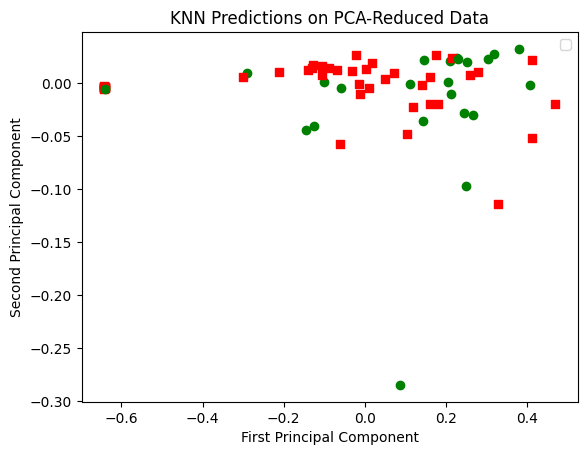

In [351]:
colors = {0: 'green', 1: 'red'}
markers = {0: 'o', 1: 's'}
for i, (x, y) in enumerate(zip(x_test_pca, y_pred)):
    plt.scatter(x[0], x[1], color=colors[y], marker=markers[y])
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KNN Predictions on PCA-Reduced Data')
plt.show()

## Asignación 5

Entrene un modelo de Naive Bayes (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

In [352]:
reviews = data['CONTENT'].values
labels = data['CLASS'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [353]:
nb = NaiveBayesClassifier()
nb.fit(train_sentences, train_labels)
pred = nb.predict(test_sentences)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred))


Predicting: 100%|██████████| 88/88 [00:00<00:00, 7997.81it/s]

Accuracy of prediction on test set :  0.8409090909090909


In [354]:
def preprocesar_comentario(comentario):
    # Realizar el preprocesamiento necesario, por ejemplo:
    comentario = comentario.lower()
    comentario = re.sub(r'\d+', '', comentario)
    comentario = re.sub(r'[^\w\s]', '', comentario)
    comentario = comentario.strip()
    stopwords = nltk.corpus.stopwords.words('english')
    comentario = ' '.join([palabra for palabra in comentario.split() if palabra not in stopwords])
    return comentario


new_comments = [
    "i hate this video",
    "pls contact me 55489701 free bitcoin",
    "check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y",
    "sub me pls and i will sub you back",
    "sus pls to my channel",
    "this song is beeter in live",
    "i dont know what im doing here",
    "i love this video",
]

nb = NaiveBayesClassifier()
nb.fit(train_sentences, train_labels)

for x in new_comments:
    nuevo_comentario_preprocesado = preprocesar_comentario(x)
    es_spam = nb.predict([nuevo_comentario_preprocesado])[0]

    if es_spam == 1:
        print('El comentario "{}" es spam.'.format(x))
    else:
        print('El comentario "{}" no es spam.'.format(x))



Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "i hate this video" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "pls contact me 55489701 free bitcoin" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "sub me pls and i will sub you back" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "sus pls to my channel" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "this song is beeter in live" no es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


El comentario "i dont know what im doing here" es spam.


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

El comentario "i love this video" no es spam.
